## Load Library

In [1]:
import os
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 

import xml.etree.ElementTree as ET
import cv2
import time

## Parse annotation into dataframe

In [2]:
df = pd.DataFrame(columns=['image_path', 'xmin', 'ymin', 'xmax', 'ymax'])
annot_dir = './license_data/annotations/'
image_dir = './license_data/images/'
for i, file in enumerate(os.listdir(annot_dir)):
    annot_path= os.path.join(annot_dir, file)
    tree = ET.parse(annot_path)
    root = tree.getroot()

    # Extracting information from the XML
    filename = root.find('filename').text
    image_path = file_path= os.path.join(image_dir, filename)
    
    object_element = root.find('object')
    bndbox_element = object_element.find('bndbox')
    xmin = int(bndbox_element.find('xmin').text)
    ymin = int(bndbox_element.find('ymin').text)
    xmax = int(bndbox_element.find('xmax').text)
    ymax = int(bndbox_element.find('ymax').text)
    
    df.loc[i] = [image_path, xmin, ymin, xmax, ymax]

In [3]:
df.head()

,image_path,xmin,ymin,xmax,ymax
0,./license_data/images/Cars0.png,226,125,419,173
1,./license_data/images/Cars1.png,134,128,262,160
2,./license_data/images/Cars10.png,140,5,303,148
3,./license_data/images/Cars100.png,175,114,214,131
4,./license_data/images/Cars101.png,167,202,240,220


## Verify data

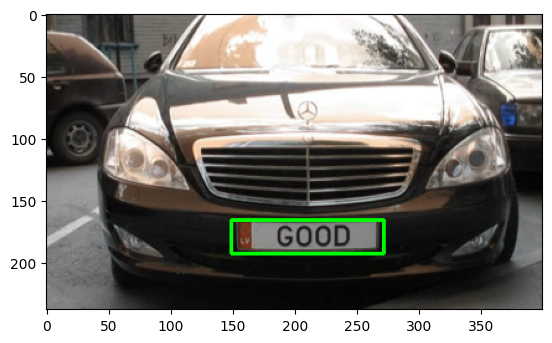

In [4]:
example = df.loc[87]
img = cv2.imread(example['image_path'])
cv2.rectangle(img, (example['xmin'], example['ymin']), (example['xmax'], example['ymax']), (0, 255, 0), 2)
plt.imshow(img)

## Create dataset

In [5]:
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import transforms
import torch
from torch import nn
from torch.utils.data import DataLoader

In [6]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

In [7]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        image = Image.open(img_path).convert('RGB')
        W, H = image.size

        coords = self.dataframe.iloc[idx, 1:].to_numpy(dtype='float32')
        labels = torch.tensor([coords[0]/W, coords[1]/H, coords[2]/W, coords[3]/H], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, labels

In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [9]:
# Create custom datasets for training and validation
train_dataset = CustomDataset(dataframe=train_df, transform=transform)
test_dataset = CustomDataset(dataframe=test_df, transform=transform)

# Create DataLoader instances for training and validation
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Create models

In [10]:
import torchvision.models as models

In [14]:
model = models.resnet34(weights='ResNet34_Weights.DEFAULT')

# Freeze all the parameters in the pretrained model
for param in model.parameters():
    param.requires_grad = False

# Add a custom classifier
classifier = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 4)
)

# Replace the existing classifier with the custom classifier
model.fc = classifier

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Train model

In [16]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

In [17]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [18]:
writer = SummaryWriter()

# Training loop
num_epochs = 150

train_losses = []
test_losses = [] 
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Average loss for the epoch
    avg_loss = running_loss / len(train_loader)

    # Print and log the average loss
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_loss:.4f}", end='')
    writer.add_scalar('Loss/train', avg_loss, epoch)
    train_losses.append(avg_loss)

    # Evaluation on the test set
    model.eval()
    test_running_loss = 0.0

    with torch.no_grad():
        for test_images, test_labels in test_loader:
            test_images, test_labels = test_images.to(device), test_labels.to(device)

            # Forward pass for evaluation
            test_outputs = model(test_images)

            # Compute loss for evaluation
            test_loss = criterion(test_outputs, test_labels)

            test_running_loss += test_loss.item()

    # Average loss on the test set
    avg_test_loss = test_running_loss / len(test_loader)

    # Print and log the average test loss
    print(f", Test Loss: {avg_test_loss:.4f}")
    writer.add_scalar('Loss/test', avg_test_loss, epoch)
    test_losses.append(avg_test_loss)

# Close the TensorBoard writer
writer.close()

Epoch [1/150], Training Loss: 0.0602, Test Loss: 0.0339
Epoch [2/150], Training Loss: 0.0265, Test Loss: 0.0297
Epoch [3/150], Training Loss: 0.0234, Test Loss: 0.0267
Epoch [4/150], Training Loss: 0.0216, Test Loss: 0.0252
Epoch [5/150], Training Loss: 0.0203, Test Loss: 0.0245
Epoch [6/150], Training Loss: 0.0193, Test Loss: 0.0238
Epoch [7/150], Training Loss: 0.0170, Test Loss: 0.0210
Epoch [8/150], Training Loss: 0.0162, Test Loss: 0.0245
Epoch [9/150], Training Loss: 0.0147, Test Loss: 0.0212
Epoch [10/150], Training Loss: 0.0138, Test Loss: 0.0211
Epoch [11/150], Training Loss: 0.0137, Test Loss: 0.0214
Epoch [12/150], Training Loss: 0.0132, Test Loss: 0.0208
Epoch [13/150], Training Loss: 0.0128, Test Loss: 0.0199
Epoch [14/150], Training Loss: 0.0118, Test Loss: 0.0207
Epoch [15/150], Training Loss: 0.0109, Test Loss: 0.0228
Epoch [16/150], Training Loss: 0.0100, Test Loss: 0.0277
Epoch [17/150], Training Loss: 0.0098, Test Loss: 0.0236
Epoch [18/150], Training Loss: 0.0097, T

Text(0.5, 1.0, 'train/val loss')

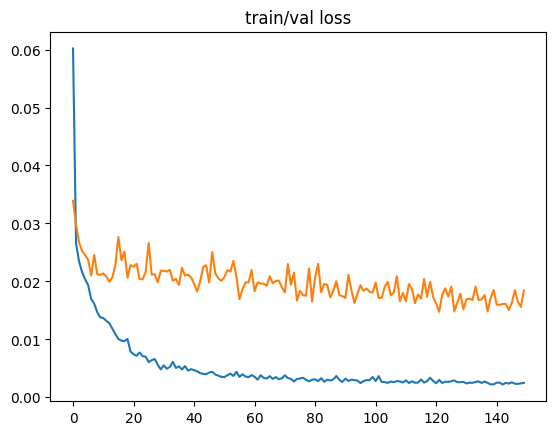

In [23]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.title('train/val loss')

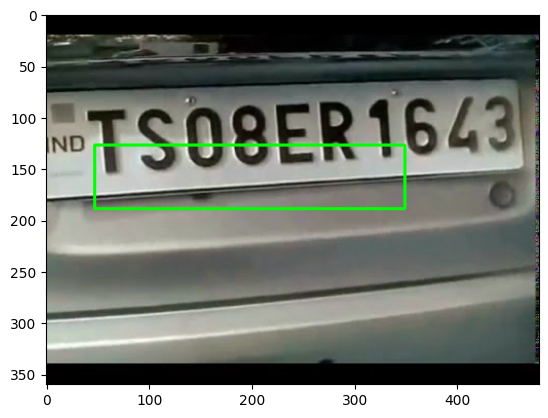

In [22]:
test_ex = test_df.iloc[2]

img_ex = Image.open(test_ex['image_path']).convert('RGB')
W, H = img_ex.size
input_ex = transform(img_ex).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(input_ex)
    
np_output = output.cpu().numpy()
coords_output = (np_output[0] * (W, H, W, H)).astype(np.int32)

img = cv2.imread(test_ex['image_path'])
cv2.rectangle(img, (coords_output[0], coords_output[1]), (coords_output[2], coords_output[3]), (0, 255, 0), 2)
plt.imshow(img)